In [1]:
import tensorflow as tf
from keras import layers, models, applications
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import LearningRateScheduler
import time

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [3]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [4]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.15, random_state=42, stratify=y_train)

### تبدیل برچسب‌ها به one-hot encoding

In [5]:
y_train_categorical = tf.keras.utils.to_categorical(y_train, 10)
y_val_categorical = tf.keras.utils.to_categorical(y_val, 10)
y_test_categorical = tf.keras.utils.to_categorical(y_test, 10)

In [6]:
print(f"Data shapes - Train: {x_train.shape}, Val: {x_val.shape}, Test: {x_test.shape}")

Data shapes - Train: (42500, 32, 32, 3), Val: (7500, 32, 32, 3), Test: (10000, 32, 32, 3)


### 1. شبکه کانولوشنال پایه


In [7]:
def create_cnn_model(with_pooling=True, pool_stride=2):
    model = models.Sequential()

    # بلوک اول
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                           input_shape=(32, 32, 3)))
    model.add(layers.BatchNormalization())
    if with_pooling:
        model.add(layers.MaxPooling2D((2, 2), strides=pool_stride))

    # بلوک دوم
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    if with_pooling:
        model.add(layers.MaxPooling2D((2, 2), strides=pool_stride))

    # بلوک سوم
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    if with_pooling:
        model.add(layers.MaxPooling2D((2, 2), strides=pool_stride))

     # بلوک چهارم
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalAveragePooling2D())

    # لایه‌های کاملاً متصل
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(10, activation='softmax'))

    return model

### شبکه Dense

In [8]:
def create_dense_model():
    model = models.Sequential([
        layers.Flatten(input_shape=(32, 32, 3)),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

### توابع تنظیم نرخ یادگیری

In [10]:
def exponential_decay(epoch, lr):
    return lr * 0.9

def one_cycle_schedule(epoch, lr_max=0.01, epochs_total=50):
    if epoch < epochs_total * 0.3:
        return lr_max * (epoch / (epochs_total * 0.3))
    elif epoch < epochs_total * 0.7:
        return lr_max
    else:
        return lr_max * (1 - (epoch - epochs_total * 0.7) / (epochs_total * 0.3))

### آموزش و ارزیابی مدل‌ها

In [12]:
def train_and_evaluate_model(model, model_name, x_train, y_train, x_val, y_val,
                           x_test, y_test, epochs=50, lr_scheduler=None):
    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    callbacks = []
    if lr_scheduler:
        callbacks.append(LearningRateScheduler(lr_scheduler))

    start_time = time.time()

    history = model.fit(x_train, y_train,
                       epochs=epochs,
                       batch_size=128,
                       validation_data=(x_val, y_val),
                       callbacks=callbacks,
                       verbose=1)

    training_time = time.time() - start_time


    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)

    return history, test_loss, test_accuracy, training_time

### آزمایش‌های مختلف

In [13]:
results = {}

# آزمایش 1: شبکه Dense
print("Training Dense Network...")
dense_model = create_dense_model()
dense_history, dense_test_loss, dense_test_accuracy, dense_time = train_and_evaluate_model(
    dense_model, "Dense", x_train, y_train_categorical, x_val, y_val_categorical,
    x_test, y_test_categorical, epochs=50
)
results['dense'] = {
    'history': dense_history,
    'test_accuracy': dense_test_accuracy,
    'test_loss': dense_test_loss,
    'time': dense_time
}

Training Dense Network...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.1535 - loss: 2.2782 - val_accuracy: 0.2577 - val_loss: 1.9992
Epoch 2/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2428 - loss: 2.0270 - val_accuracy: 0.2951 - val_loss: 1.9382
Epoch 3/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2692 - loss: 1.9647 - val_accuracy: 0.3296 - val_loss: 1.9038
Epoch 4/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2791 - loss: 1.9363 - val_accuracy: 0.3357 - val_loss: 1.9031
Epoch 5/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2797 - loss: 1.9325 - val_accuracy: 0.3421 - val_loss: 1.8903
Epoch 6/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2993 - loss: 1.8875 - val_accuracy: 0.3176 - val_loss: 1.9319
Epoch 7/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2962 - loss: 1.8964 - val_accuracy: 0.3503 - val_loss: 1.8604
Epoch 8/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2964 - loss: 1.9011 - val_accuracy: 

### CNN با Pooling

In [14]:
print("Training CNN with Pooling...")
cnn_pool_model = create_cnn_model(with_pooling=True, pool_stride=2)
cnn_pool_history, cnn_pool_test_loss, cnn_pool_test_accuracy, cnn_pool_time = train_and_evaluate_model(
    cnn_pool_model, "CNN_with_Pooling", x_train, y_train_categorical,
    x_val, y_val_categorical, x_test, y_test_categorical, epochs=50
)
results['cnn_pool'] = {
    'history': cnn_pool_history,
    'test_accuracy': cnn_pool_test_accuracy,
    'test_loss': cnn_pool_test_loss,
    'time': cnn_pool_time
}

Training CNN with Pooling...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.4025 - loss: 1.6258 - val_accuracy: 0.1244 - val_loss: 3.9199
Epoch 2/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.6399 - loss: 1.0185 - val_accuracy: 0.5549 - val_loss: 1.3075
Epoch 3/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7237 - loss: 0.8054 - val_accuracy: 0.6752 - val_loss: 0.9162
Epoch 4/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7606 - loss: 0.6836 - val_accuracy: 0.7119 - val_loss: 0.8579
Epoch 5/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8041 - loss: 0.5613 - val_accuracy: 0.6991 - val_loss: 0.9415
Epoch 6/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8312 - loss: 0.4914 - val_accuracy: 0.6619 - val_loss: 1.1355
Epoch 7/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8584 - loss: 0.4120 - val_accuracy: 0.6961 - val_loss: 1.0771
Epoch 8/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8625 - loss: 0.3961 - val_acc

### CNN بدون Pooling

In [15]:
print("Training CNN without Pooling...")
cnn_no_pool_model = create_cnn_model(with_pooling=False)
cnn_no_pool_history, cnn_no_pool_test_loss, cnn_no_pool_test_accuracy, cnn_no_pool_time = train_and_evaluate_model(
    cnn_no_pool_model, "CNN_no_Pooling", x_train, y_train_categorical,
    x_val, y_val_categorical, x_test, y_test_categorical, epochs=50
)
results['cnn_no_pool'] = {
    'history': cnn_no_pool_history,
    'test_accuracy': cnn_no_pool_test_accuracy,
    'test_loss': cnn_no_pool_test_loss,
    'time': cnn_no_pool_time
}

Training CNN without Pooling...
Epoch 1/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 49s 101ms/step - accuracy: 0.3497 - loss: 1.7325 - val_accuracy: 0.1701 - val_loss: 3.0638
Epoch 2/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - accuracy: 0.5623 - loss: 1.2148 - val_accuracy: 0.5087 - val_loss: 1.2938
Epoch 3/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - accuracy: 0.6268 - loss: 1.0359 - val_accuracy: 0.6332 - val_loss: 1.0347
Epoch 4/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.6800 - loss: 0.8936 - val_accuracy: 0.6715 - val_loss: 0.9549
Epoch 5/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.7286 - loss: 0.7690 - val_accuracy: 0.6515 - val_loss: 1.0663
Epoch 6/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 22s 66ms/step - accuracy: 0.7427 - loss: 0.7359 - val_accuracy: 0.6599 - val_loss: 1.0381
Epoch 7/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - accuracy: 0.7777 - loss: 0.6372 - val_accuracy: 0.6528 - val_loss: 1.0607
Epoch 8/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - a

### CNN با Exponential LR

In [17]:
print("Training CNN with Exponential LR...")
cnn_exp_model = create_cnn_model(with_pooling=True, pool_stride=2)
cnn_exp_history, cnn_exp_test_loss, cnn_exp_test_accuracy, cnn_exp_time = train_and_evaluate_model(
    cnn_exp_model, "CNN_Exponential_LR", x_train, y_train_categorical,
    x_val, y_val_categorical, x_test, y_test_categorical, epochs=50,
    lr_scheduler=exponential_decay
)
results['cnn_exp'] = {
    'history': cnn_exp_history,
    'test_accuracy': cnn_exp_test_accuracy,
    'test_loss': cnn_exp_test_loss,
    'time': cnn_exp_time
}

Training CNN with Exponential LR...
Epoch 1/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.3974 - loss: 1.6412 - val_accuracy: 0.2881 - val_loss: 2.3429 - learning_rate: 9.0000e-04
Epoch 2/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6367 - loss: 1.0362 - val_accuracy: 0.6420 - val_loss: 1.0102 - learning_rate: 8.1000e-04
Epoch 3/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7158 - loss: 0.8108 - val_accuracy: 0.6473 - val_loss: 1.0116 - learning_rate: 7.2900e-04
Epoch 4/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7622 - loss: 0.6975 - val_accuracy: 0.6967 - val_loss: 0.8950 - learning_rate: 6.5610e-04
Epoch 5/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8182 - loss: 0.5323 - val_accuracy: 0.7301 - val_loss: 0.8164 - learning_rate: 5.9049e-04
Epoch 6/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8370 - loss: 0.4674 - val_accuracy: 0.7232 - val_loss: 0.8922 - learning_rate: 5.3144e-04
Epoch 7/50
333/333 ━━

### CNN با OneCycle LR

In [18]:
print("Training CNN with OneCycle LR...")
cnn_cycle_model = create_cnn_model(with_pooling=True, pool_stride=2)
cnn_cycle_history, cnn_cycle_test_loss, cnn_cycle_test_accuracy, cnn_cycle_time = train_and_evaluate_model(
    cnn_cycle_model, "CNN_OneCycle_LR", x_train, y_train_categorical,
    x_val, y_val_categorical, x_test, y_test_categorical, epochs=50,
    lr_scheduler=one_cycle_schedule
)
results['cnn_cycle'] = {
    'history': cnn_cycle_history,
    'test_accuracy': cnn_cycle_test_accuracy,
    'test_loss': cnn_cycle_test_loss,
    'time': cnn_cycle_time
}

Training CNN with OneCycle LR...
Epoch 1/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.1024 - loss: 2.3909 - val_accuracy: 0.1056 - val_loss: 2.3737 - learning_rate: 0.0000e+00
Epoch 2/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.1056 - loss: 2.3842 - val_accuracy: 0.1051 - val_loss: 2.3297 - learning_rate: 0.0000e+00
Epoch 3/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.1058 - loss: 2.3855 - val_accuracy: 0.1096 - val_loss: 2.3289 - learning_rate: 0.0000e+00
Epoch 4/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1035 - loss: 2.3865 - val_accuracy: 0.1099 - val_loss: 2.3287 - learning_rate: 0.0000e+00
Epoch 5/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1011 - loss: 2.3893 - val_accuracy: 0.1104 - val_loss: 2.3290 - learning_rate: 0.0000e+00
Epoch 6/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.1029 - loss: 2.3837 - val_accuracy: 0.1103 - val_loss: 2.3288 - learning_rate: 0.0000e+00
Epoch 7/50
333/333 ━━━━━

### CNN با Stride 4

In [19]:
print("Training CNN with Stride 4...")
cnn_stride4_model = create_cnn_model(with_pooling=True, pool_stride=4)
cnn_stride4_history, cnn_stride4_test_loss, cnn_stride4_test_accuracy, cnn_stride4_time = train_and_evaluate_model(
    cnn_stride4_model, "CNN_Stride4", x_train, y_train_categorical,
    x_val, y_val_categorical, x_test, y_test_categorical, epochs=50
)
results['cnn_stride4'] = {
    'history': cnn_stride4_history,
    'test_accuracy': cnn_stride4_test_accuracy,
    'test_loss': cnn_stride4_test_loss,
    'time': cnn_stride4_time
}

Training CNN with Stride 4...
Epoch 1/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.3139 - loss: 1.9119 - val_accuracy: 0.1444 - val_loss: 2.7184
Epoch 2/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4853 - loss: 1.4285 - val_accuracy: 0.5099 - val_loss: 1.3595
Epoch 3/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5557 - loss: 1.2562 - val_accuracy: 0.5613 - val_loss: 1.2406
Epoch 4/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5885 - loss: 1.1740 - val_accuracy: 0.5656 - val_loss: 1.2299
Epoch 5/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6119 - loss: 1.1059 - val_accuracy: 0.5273 - val_loss: 1.4023
Epoch 6/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6388 - loss: 1.0389 - val_accuracy: 0.5873 - val_loss: 1.1811
Epoch 7/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6730 - loss: 0.9496 - val_accuracy: 0.5875 - val_loss: 1.2038
Epoch 8/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6592 -

## ResNet50 Network

In [20]:
def create_resnet_model(trainable_layers=0):
    base_model = applications.ResNet50(weights='imagenet',
                                      include_top=False,
                                      input_shape=(32, 32, 3))

    # فریز کردن لایه‌های پایه
    base_model.trainable = False

    # اگر trainable_layers > 0 باشد، تعدادی از لایه‌ها را trainable می‌کنیم
    if trainable_layers > 0:
        base_model.trainable = True
        for layer in base_model.layers[:-trainable_layers]:
            layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])

    return model

### ResNet کاملاً فریز شده

In [21]:
print("Training Frozen ResNet50...")
resnet_frozen = create_resnet_model(trainable_layers=0)
resnet_frozen_history, resnet_frozen_test_loss, resnet_frozen_test_accuracy, resnet_frozen_time = train_and_evaluate_model(
    resnet_frozen, "ResNet_Frozen", x_train, y_train_categorical,
    x_val, y_val_categorical, x_test, y_test_categorical, epochs=50
)
results['resnet_frozen'] = {
    'history': resnet_frozen_history,
    'test_accuracy': resnet_frozen_test_accuracy,
    'test_loss': resnet_frozen_test_loss,
    'time': resnet_frozen_time
}

Training Frozen ResNet50...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 28s 50ms/step - accuracy: 0.1274 - loss: 2.4237 - val_accuracy: 0.2096 - val_loss: 2.1541
Epoch 2/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.1771 - loss: 2.1739 - val_accuracy: 0.2297 - val_loss: 2.1145
Epoch 3/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.1792 - loss: 2.1550 - val_accuracy: 0.2373 - val_loss: 2.0751
Epoch 4/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.1878 - loss: 2.1484 - val_accuracy: 0.2408 - val_loss: 2.0307
Epoch 5/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.1808 - loss: 2.1427 - val_accuracy: 0.2384 - val_loss: 2.0327
Epoch 6/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.1993 - loss: 2.1185 - val_accuracy: 0.2783 - val_loss: 1.9941
Epoch 7/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.2022 - loss: 2.1103 - val_accuracy: 0.2760 - val_loss: 1.9892
Epoch 8/50
333/33

### ResNet با آخرین لایه trainable

In [22]:
print("Training ResNet50 with Last Layer Trainable...")
resnet_trainable = create_resnet_model(trainable_layers=10)
resnet_trainable_history, resnet_trainable_test_loss, resnet_trainable_test_accuracy, resnet_trainable_time = train_and_evaluate_model(
    resnet_trainable, "ResNet_Trainable", x_train, y_train_categorical,
    x_val, y_val_categorical, x_test, y_test_categorical, epochs=50
)
results['resnet_trainable'] = {
    'history': resnet_trainable_history,
    'test_accuracy': resnet_trainable_test_accuracy,
    'test_loss': resnet_trainable_test_loss,
    'time': resnet_trainable_time
}

Training ResNet50 with Last Layer Trainable...
Epoch 1/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 33s 54ms/step - accuracy: 0.2425 - loss: 2.2058 - val_accuracy: 0.1016 - val_loss: 8.1264
Epoch 2/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.3902 - loss: 1.7307 - val_accuracy: 0.1739 - val_loss: 3.1532
Epoch 3/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.4388 - loss: 1.6167 - val_accuracy: 0.1951 - val_loss: 2.4098
Epoch 4/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.4637 - loss: 1.5640 - val_accuracy: 0.1231 - val_loss: 3.0191
Epoch 5/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.4773 - loss: 1.5066 - val_accuracy: 0.1915 - val_loss: 2.3171
Epoch 6/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.5001 - loss: 1.4530 - val_accuracy: 0.2344 - val_loss: 2.0855
Epoch 7/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5062 - loss: 1.4395 - val_accuracy: 0.2844 - val_loss: 2.1414
Epoch 8/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/s

# رسم نمودارهای مقایسه‌ای

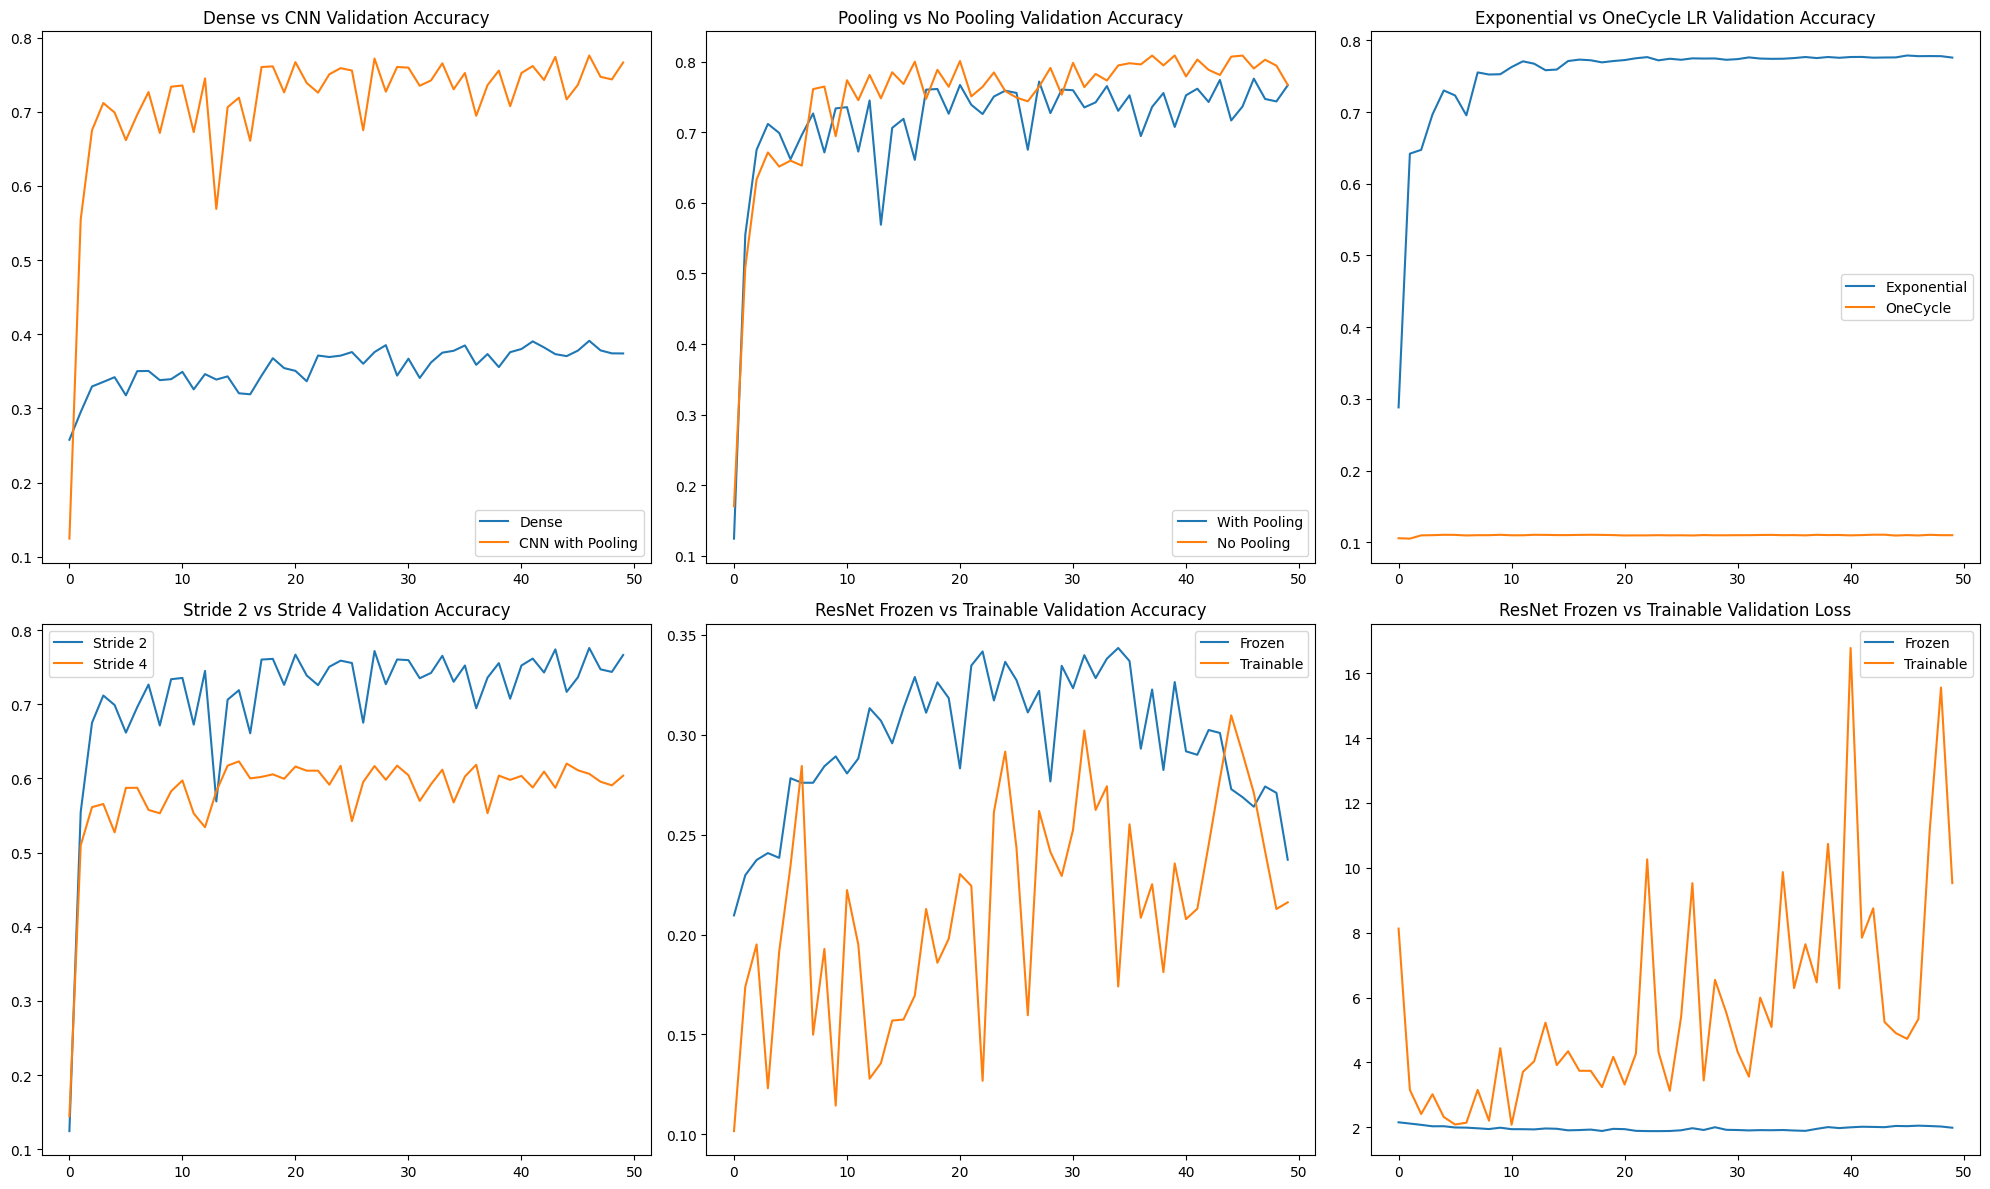

In [23]:
def plot_comparisons(results):
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    # مقایسه Dense vs CNN
    axes[0,0].plot(results['dense']['history'].history['val_accuracy'], label='Dense')
    axes[0,0].plot(results['cnn_pool']['history'].history['val_accuracy'], label='CNN with Pooling')
    axes[0,0].set_title('Dense vs CNN Validation Accuracy')
    axes[0,0].legend()

    # مقایسه Pooling vs No Pooling
    axes[0,1].plot(results['cnn_pool']['history'].history['val_accuracy'], label='With Pooling')
    axes[0,1].plot(results['cnn_no_pool']['history'].history['val_accuracy'], label='No Pooling')
    axes[0,1].set_title('Pooling vs No Pooling Validation Accuracy')
    axes[0,1].legend()

    # مقایسه Exponential vs OneCycle
    axes[0,2].plot(results['cnn_exp']['history'].history['val_accuracy'], label='Exponential')
    axes[0,2].plot(results['cnn_cycle']['history'].history['val_accuracy'], label='OneCycle')
    axes[0,2].set_title('Exponential vs OneCycle LR Validation Accuracy')
    axes[0,2].legend()

        # مقایسه Stride 2 vs Stride 4
    axes[1,0].plot(results['cnn_pool']['history'].history['val_accuracy'], label='Stride 2')
    axes[1,0].plot(results['cnn_stride4']['history'].history['val_accuracy'], label='Stride 4')
    axes[1,0].set_title('Stride 2 vs Stride 4 Validation Accuracy')
    axes[1,0].legend()

    # مقایسه ResNet Frozen vs Trainable
    axes[1,1].plot(results['resnet_frozen']['history'].history['val_accuracy'], label='Frozen')
    axes[1,1].plot(results['resnet_trainable']['history'].history['val_accuracy'], label='Trainable')
    axes[1,1].set_title('ResNet Frozen vs Trainable Validation Accuracy')
    axes[1,1].legend()

    # نمودار Loss برای ResNet
    axes[1,2].plot(results['resnet_frozen']['history'].history['val_loss'], label='Frozen')
    axes[1,2].plot(results['resnet_trainable']['history'].history['val_loss'], label='Trainable')
    axes[1,2].set_title('ResNet Frozen vs Trainable Validation Loss')
    axes[1,2].legend()

    plt.tight_layout()
    plt.show()

plot_comparisons(results)

# گزارش نتایج

In [24]:
print("\n" + "="*80)
print("COMPARISON RESULTS")
print("="*80)

print(f"\n1. DENSE NETWORK:")
print(f"   Test Accuracy: {results['dense']['test_accuracy']:.4f}")
print(f"   Training Time: {results['dense']['time']:.2f} seconds")

print(f"\n2. CNN WITH POOLING:")
print(f"   Test Accuracy: {results['cnn_pool']['test_accuracy']:.4f}")
print(f"   Training Time: {results['cnn_pool']['time']:.2f} seconds")

print(f"\n3. CNN WITHOUT POOLING:")
print(f"   Test Accuracy: {results['cnn_no_pool']['test_accuracy']:.4f}")
print(f"   Training Time: {results['cnn_no_pool']['time']:.2f} seconds")

print(f"\n4. LEARNING RATE SCHEDULERS:")
print(f"   Exponential LR - Test Accuracy: {results['cnn_exp']['test_accuracy']:.4f}")
print(f"   OneCycle LR - Test Accuracy: {results['cnn_cycle']['test_accuracy']:.4f}")

print(f"\n5. POOLING STRIDE COMPARISON:")
print(f"   Stride 2 - Test Accuracy: {results['cnn_pool']['test_accuracy']:.4f}")
print(f"   Stride 4 - Test Accuracy: {results['cnn_stride4']['test_accuracy']:.4f}")

print(f"\n6. RESNET TRANSFER LEARNING:")
print(f"   Frozen - Test Accuracy: {results['resnet_frozen']['test_accuracy']:.4f}")
print(f"   Trainable - Test Accuracy: {results['resnet_trainable']['test_accuracy']:.4f}")



COMPARISON RESULTS

1. DENSE NETWORK:
   Test Accuracy: 0.3806
   Training Time: 102.98 seconds

2. CNN WITH POOLING:
   Test Accuracy: 0.7609
   Training Time: 209.48 seconds

3. CNN WITHOUT POOLING:
   Test Accuracy: 0.7668
   Training Time: 1028.60 seconds

4. LEARNING RATE SCHEDULERS:
   Exponential LR - Test Accuracy: 0.7790
   OneCycle LR - Test Accuracy: 0.1135

5. POOLING STRIDE COMPARISON:
   Stride 2 - Test Accuracy: 0.7609
   Stride 4 - Test Accuracy: 0.6059

6. RESNET TRANSFER LEARNING:
   Frozen - Test Accuracy: 0.2362
   Trainable - Test Accuracy: 0.2168


### گزارش معماری شبکه کانولوشنال

In [25]:
print(f"\n7. CNN ARCHITECTURE DETAILS:")
print("   - 4 Convolutional Blocks")
print("   - Kernel sizes: 3x3 in all layers")
print("   - Filters: 32 -> 64 -> 128 -> 256")
print("   - Batch Normalization after each Conv layer")
print("   - Global Average Pooling before Dense layers")
print("   - Dense layers: 512 -> 256 -> 10")


7. CNN ARCHITECTURE DETAILS:
   - 4 Convolutional Blocks
   - Kernel sizes: 3x3 in all layers
   - Filters: 32 -> 64 -> 128 -> 256
   - Batch Normalization after each Conv layer
   - Global Average Pooling before Dense layers
   - Dense layers: 512 -> 256 -> 10
